In [57]:
import os
import numpy as np
import cv2
import tensorflow as tf
import keras
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Step 1 - Preparing dataset

In [58]:
import random

def get_input_output_paths(root_dir, sub_dirs, max_samples=None):
    input_img_paths = []
    target_img_paths = []
    samples_per_dir = max_samples // len(sub_dirs) if max_samples else None
    for sub_dir in sub_dirs:
        input_dir = os.path.join(root_dir, sub_dir, 'image')
        sub_input_img_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
        random.shuffle(sub_input_img_paths)
        sub_target_img_paths = list(map(lambda x: x.replace("image", "indexLabel"), sub_input_img_paths))
        
        if samples_per_dir:
            sub_input_img_paths = sub_input_img_paths[:samples_per_dir]
            sub_target_img_paths = sub_target_img_paths[:samples_per_dir]
        
        input_img_paths.extend(sub_input_img_paths)
        target_img_paths.extend(sub_target_img_paths)
    return input_img_paths, target_img_paths

input_img_paths, target_img_paths = get_input_output_paths('WildScenes2d', ['V-01', 'V-02', 'V-03'], 1000)

# print(input_img_paths)
# print(target_img_paths)

In [59]:
import random

input_dir = "V-01/image/"
target_dir = "V-01/indexLabel"
img_size = (256, 256)
num_classes = 19
batch_size = 16
input_size = 20



def get_input_output_paths_old():
    input_img_paths = [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]

    random.shuffle(input_img_paths)

    target_img_paths = list(map(lambda x: x.replace("image", "indexLabel"), input_img_paths))

    input_img_paths = input_img_paths[:input_size]
    target_img_paths = target_img_paths[:input_size]
    

    return input_img_paths, target_img_paths

# comment out the following after the complete dataset is downloaded in WildScenes2d and
# replace with the commented function call in the cell above
# input_img_paths, target_img_paths = get_input_output_paths_old()

print("Number of samples:", len(input_img_paths))


Number of samples: 999


In [60]:

def load_mask(img_path):
    target_img = tf_io.read_file(img_path)
    target_img = tf_io.decode_png(target_img, channels=1)
    target_img = tf_image.convert_image_dtype(target_img, "uint8")
    
    return target_img

def load_image(img_path):
    input_img = tf_io.read_file(img_path)
    input_img = tf_io.decode_png(input_img, channels=3)
    input_img = tf_image.resize(input_img, img_size)
    input_img = tf_image.convert_image_dtype(input_img, "float32")
    
    return input_img

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")
        
        target_one_hot = tf.one_hot(tf.squeeze(target_img), num_classes)
    
        return input_img, target_one_hot

    # limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
        
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [61]:
from sklearn.model_selection import train_test_split

def get_majority_values(filepath):
    arr = np.array(load_mask(filepath))
    flat_arr = arr.flatten()
    
    # Get unique values and their counts
    unique, counts = np.unique(flat_arr, return_counts=True)
    
    # Find the maximum count
    max_count = counts.max()
    
    # Get all values with the maximum count
    majority_values = unique[counts == max_count]
    
    return majority_values[0]

def get_dataset_majority_values(dataset):
    return np.array(list(map(get_majority_values, dataset)))

def train_val_test_split(X_all, y_all, test_size=0.2, validation_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=test_size, stratify=get_dataset_majority_values(y_all), random_state=42)
    X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=validation_size/(1-test_size), stratify=get_dataset_majority_values(y_train), random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(input_img_paths, target_img_paths)

print("Classes in the dataset:", get_dataset_majority_values(target_img_paths))
print("Number of train samples:", len(X_train))
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test))

train_dataset = get_dataset(
    batch_size,
    img_size,
    X_train,
    y_train,
)

valid_dataset = get_dataset(
    batch_size,
    img_size,
    X_val,
    y_val,
)

Classes in the dataset: [ 8  8  8  8  8  8  8  8  8  8  8  8  8  8 17  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 17  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8 17  8  8  8  2  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8 17  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8 17  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8 17  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8

In [62]:
def build_unet(shape, num_classes):
    def conv_block(inputs, filters, pool=True):
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        if pool == True:
            p = MaxPooling2D((2, 2))(x)
            return x, p
        else:
            return x
        
    inputs = Input(shape)

    # Encoder Layer
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    # Bridge Layer
    b1 = conv_block(p4, 128, pool=False)

    # Decoder Layer
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)
    
    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)
    
    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    # Output layer
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)
    return Model(inputs, output)

# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x

# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p

# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# def build_unet(input_shape, num_classes):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b1 = conv_block(p4, 1024)

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

#     model = Model(inputs, outputs, name="U-Net")
#     return model

# model = unet_model((256, 256, 3), num_classes)
model = build_unet((256, 256, 3), num_classes)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     13,872 │ max_pooling2d_1[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     27,712 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ activation_7[0][

 Total params: 311,731 (1.19 MB)

 Trainable params: 310,835 (1.19 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [63]:
@tf.keras.utils.register_keras_serializable()
class CustomMeanIoU(MeanIoU):
    def __init__(self, num_classes=None, name=None, dtype=None, **kwargs):
        super(CustomMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs)

    @tf.function(reduce_retracing=True)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.math.argmax(y_true, axis=-1)
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        config = super(CustomMeanIoU, self).get_config()
        config.update({
            "num_classes": self.num_classes,
            "name": self.name,
            "dtype": self.dtype,
        })
        return config

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=[MeanIoU(num_classes=num_classes)])

callbacks = [
    ModelCheckpoint("models/unet_final_checkpoint.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1),
]

epochs = 200

model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    shuffle=True,
    verbose=1,
)

model.save('models/unet_final_model.keras')

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - loss: 2.5912 - mean_io_u: 0.4706 - val_loss: 2.6541 - val_mean_io_u: 0.4707 - learning_rate: 1.0000e-04
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - loss: 2.1317 - mean_io_u: 0.4706 - val_loss: 2.6142 - val_mean_io_u: 0.4707 - learning_rate: 1.0000e-04
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - loss: 1.9442 - mean_io_u: 0.4706 - val_loss: 2.5005 - val_mean_io_u: 0.4707 - learning_rate: 1.0000e-04
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - loss: 1.8290 - mean_io_u: 0.4706 - val_loss: 2.3217 - val_mean_io_u: 0.4707 - learning_rate: 1.0000e-04
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 1.7523 - mean_io_u: 0.4706 - val_loss: 2.1323 - val_mean_io_u: 0.4707 - learning_rate: 1.0000e-04
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - loss: 1.6904 - mean_io_u: 0.4706 - val_loss: 1.9727 - val_mean_io_u: 0.4707 - learning_rate: 1.0000e-04
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step 

In [64]:
model = tf.keras.models.load_model('models/unet_final_model.keras')

In [65]:
from sklearn.metrics import jaccard_score, accuracy_score, f1_score

y_pred = model.predict(get_dataset(batch_size, img_size, X_test, y_test))
y_pred_whole = np.argmax(y_pred, axis=-1).flatten()

y_test_imgs = [load_mask(x) for x in y_test]
y_test_whole = np.array([tf_image.resize(x, (256, 256)) for x in y_test_imgs])
y_test_whole = y_test_whole.flatten().astype(int)

print(len(y_pred_whole))
print(len(y_test_whole))

iou = jaccard_score(y_test_whole, y_pred_whole, average=None)
print(f'IoU for each class: {iou}')
print(f'Mean IoU: {np.mean(iou)}')
print(f'Accuracy: {accuracy_score(y_test_whole, y_pred_whole)}')
print(f'F1: {f1_score(y_test_whole, y_pred_whole, average=None)}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step
13107200
13107200
IoU for each class: [0.77439955 0.         0.         0.         0.         0.43887632
 0.80484852 0.14812544 0.         0.         0.         0.
 0.         0.         0.         0.8127063  0.63349442]
Mean IoU: 0.21249709159161934
Accuracy: 0.8261184692382812
F1: [0.87285815 0.         0.         0.         0.         0.61002647
 0.89187376 0.25803007 0.         0.         0.         0.
 0.         0.         0.         0.8966773  0.77563095]


In [66]:
print(y_pred_whole.shape)
print(y_test_whole.shape)
print(y_pred_whole)
print(y_test_whole)

(13107200,)
(13107200,)
[ 8  8  8 ... 18 18 18]
[ 8  8  8 ... 18 18 18]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[ 8  8  8 ...  8  8  8]
 [ 8  8  8 ...  8  8  8]
 [ 8  8  8 ...  8  8  8]
 ...
 [18 18 18 ...  8  8  8]
 [18 18 18 ...  8  8 18]
 [18 18 18 ... 18 18  8]]


(-0.5, 2015.5, 1511.5, -0.5)

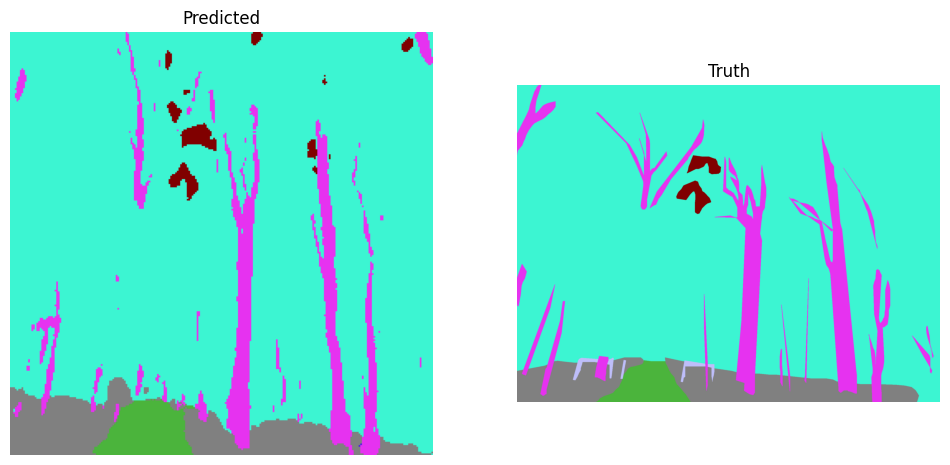

In [72]:
colours = [[0, 0, 0], 
           [75, 25, 230], 
           [75, 180, 60], 
           [25, 225, 255], 
           [200, 130, 0], 
           [180, 30, 145], 
           [240, 240, 70], 
           [230, 50, 240], 
           [60, 245, 210], 
           [75, 25, 230], 
           [128, 128, 0], 
           [40, 110, 170], 
           [200, 250, 255], 
           [0, 0, 128], 
           [195, 255, 170], 
           [0, 128, 128], 
           [190, 190, 250], 
           [128, 0, 0], 
           [128, 128, 128]]

# test_sample = "1623378124-414282018.png"
# test_sample = "1623378124-681919295.png"
test_sample = "1623377812-526645347.png"
original_size = (2016, 1512)

truth_labels = load_mask("WildScenes2d/V-01/indexLabel/" + test_sample)
truth_img = np.array([[colours[num] for num in row] for row in np.array(truth_labels).reshape(1512, 2016)])

test_img = load_image("WildScenes2d/V-01/image/" + test_sample)
y_pred = model.predict(np.expand_dims(test_img, axis=0))
y_pred_labels = np.argmax(y_pred, axis=-1)[0]
y_pred_resized = cv2.resize(y_pred_labels, original_size, interpolation=cv2.INTER_NEAREST)
predicted_img = np.array([[colours[num] for num in row] for row in y_pred_labels])

print(y_pred_labels)

import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the predicted image on the first subplot
axes[0].imshow(predicted_img)
axes[0].set_title('Predicted')
axes[0].axis('off')  # Hide axes

# Plot the truth image on the second subplot
axes[1].imshow(truth_img)
axes[1].set_title('Truth')
axes[1].axis('off')  # Hide axes